#### Colab run

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
cd drive/MyDrive/master_thesis/final_code

/content/drive/.shortcut-targets-by-id/16udig9ZMaNcASs5Maj6kv7tg-TL3PnSE/Master Thesis/final_code


In [3]:
!pip install kornia
!pip install torchinfo

#### End Colab run

In [4]:
import warnings
import time
import pickle 

from py_files.args import *

from py_files.functions import *

from py_files.dataset import *

from py_files.cnn_models import *
from py_files.mapping_models import *
from py_files.pigan_model import *

from py_files.load_utils import *
from py_files.data_utils import *
from py_files.plot_utils import *
from py_files.loss_utils import *
from py_files.train_utils import *
from py_files.save_utils import *

# Set the run you want to evaluate 

In [5]:
sorted(os.listdir(path='saved_runs'))

['pi_gan_2021_08_24_06_56_23_reconstruction_golden_cnn_run_0',
 'pi_gan_2021_08_24_06_56_32_reconstruction_4net_run_0']

In [6]:
# run = sorted(os.listdir(path='saved_runs'))[-1]
run = sorted(os.listdir(path='saved_runs'))[-2]

# run = "pi_gan_2021_07_05_10_28_52"

ARGS = load_args(run, print_changed=False)

# ARGS.sdf = True
# ARGS.sdf_split = .5
# ARGS.flip = True
# ARGS.crop = True
# ARGS.translate = True
# ARGS.rotate = True

print(run)
for var, val in vars(ARGS).items():
    print(f"{var.ljust(25)} \t {val}")

pi_gan_2021_08_24_06_56_23_reconstruction_golden_cnn_run_0
device                    	 GPU
print_models              	 False
save_models               	 True
name                      	 _reconstruction_golden_cnn_run_0
pretrained                	 None
pretrained_best_dataset   	 train
pretrained_best_loss      	 mask
pretrained_models         	 None
pretrained_lr_reset       	 None
seed                      	 34
n_coords_sample           	 5000
norm_min_max              	 [0, 1]
rotate                    	 True
translate                 	 True
crop                      	 True
stretch                   	 True
flip                      	 False
translate_max_pixels      	 20
stretch_factor            	 1.2
pcmra_epochs              	 5000
mask_epochs               	 5000
batch_size                	 24
eval_every                	 50
shuffle                   	 True
min_lr                    	 1e-05
patience                  	 50
cnn_setup                 	 golden
mapping_setup             

In [7]:
ARGS.device = "GPU"
DEVICE = set_device(ARGS)

----------------------------------
Using device for training: cuda
----------------------------------


# Evaluation

In [8]:
ARGS.batch_size = 6

train_dl, val_dl, test_dl = initialize_dataloaders(ARGS, DEVICE)

Train subjects: 82
Train batch: ('116', '44', '3', '100', '102')
Val subjects: 32
Val batch: ('10', '121', '11', '129', '131')
Test subjects: 30
Test batch: ('133', '134', '15', '142', '138')


#### Load models

In [9]:
ARGS.print_models=False
models, optims, schedulers = initialize_models_and_optims(ARGS, DEVICE)

CNN
MAPPING
SIREN
PCMRA_MAPPING
PCMRA_SIREN


In [10]:
# models["pcmra_siren"]

In [11]:
ARGS.pretrained_best_dataset = "train"
ARGS.pretrained_best_loss = "pcmra"

load_pretrained_models(run, ARGS.pretrained_best_dataset, ARGS.pretrained_best_loss,
                       models, optims, DEVICE, pretrained_models=None)

Loading params from cnn
Loading params from pcmra_mapping
Loading params from pcmra_siren


In [12]:
##### loss function #####
mask_criterion = nn.BCELoss()    
pcmra_criterion = nn.MSELoss()  
dice_criterion = calc_dice_loss

In [13]:
def save_output(dataloader, shape=[24, 128, 128], transform=False):
    pcmras = masks = surfaces = norms_x = norms_y = norms_z = mask_outs = pcmra_outs = torch.Tensor([])

    titles = []

    mask_losses, pcmra_losses, dice_losses = [], [], []

    blur_layer = initialize_blurring_layer(1.0, DEVICE)

    for batch in dataloader: 

        if transform:
            batch = transform_batch(batch, ARGS)

        idxs, subjs, projs, pcmra, coords_array, pcmra_array, mask_array, surface_array, norm_array = \
            get_siren_batch(batch, blur_layer, -1, ARGS)

        mask_out = get_complete_image(models, pcmra, coords_array, ARGS)
                
        pcmra_out = get_complete_image(models, pcmra, coords_array, ARGS, output="pcmra")

        for subj, s_pcmra_array, s_mask_array, s_surface_array, s_norm_array, s_pcmra_out, s_mask_out in zip(subjs, pcmra_array, mask_array, surface_array, norm_array, pcmra_out, mask_out):
            if ARGS.segmentation == "sdf":
                s_mask_out = 1 - F.sigmoid(s_mask_out)
            
            pcmra_losses.append(pcmra_criterion(s_pcmra_out, s_pcmra_array) .item())
            mask_losses.append(mask_criterion(s_mask_out, s_mask_array).item())
            dice_losses.append(dice_criterion(s_mask_out, s_mask_array).item())

            pcmras = torch.cat((pcmras, s_pcmra_array.cpu().view(shape).detach().permute(1, 2, 0)), 2)
            masks = torch.cat((masks, s_mask_array.cpu().view(shape).detach().permute(1, 2, 0)), 2)
            mask_outs = torch.cat((mask_outs, s_mask_out.cpu().view(shape).detach().permute(1, 2, 0)), 2)
            pcmra_outs = torch.cat((pcmra_outs, s_pcmra_out.cpu().view(shape).detach().permute(1, 2, 0)), 2)

            if ARGS.segmentation == "sdf":
                surfaces = torch.cat((surfaces, s_surface_array.cpu().view(shape).detach().permute(1, 2, 0)), 2)
                norms_x = torch.cat((norms_x, s_norm_array[:, 0:1].cpu().view(shape).detach().permute(1, 2, 0)), 2)
                norms_y = torch.cat((norms_y, s_norm_array[:, 1:2].cpu().view(shape).detach().permute(1, 2, 0)), 2)
                norms_z = torch.cat((norms_z, s_norm_array[:, 2: ].cpu().view(shape).detach().permute(1, 2, 0)), 2)
                
            titles += [f"{subj}, pcmra loss: {round(pcmra_losses[-1], 3)}, mask loss: {round(mask_losses[-1], 3)}, dice loss: {round(dice_losses[-1], 3)}" for i in range(shape[0])]
        
        break
    
    
    print("PCMRA loss:", np.array(pcmra_losses).mean().round(3))
    print("Mask loss: ", np.array(mask_losses).mean().round(3))
    print("Dice loss: ", np.array(dice_losses).mean().round(3))


    save_tuples = [(pcmras.numpy(), "pcmras"),
                   (pcmra_outs.numpy(), "pcmra output"),
                   (masks.numpy(), "masks"),
                   (mask_outs.numpy(), "mask output"),
                #    (surfaces.numpy(), "surface"),
                #    (norms_x.numpy(), "norm x"),
                #    (norms_y.numpy(), "norm y"),
                #    (norms_z.numpy(), "norm z"),
                #    ((1 - F.sigmoid(mask_outs)).numpy().round(), "mask output binary"),
                ]
    
    fig, ax = plt.subplots(1, len(save_tuples), figsize=(20,20))
    for i , (array, title) in enumerate(save_tuples): 
        ax[i].imshow(array[:, :, 10])

    path = os.path.join(os.getcwd(), "saved_results", run)
    Path(f"{path}").mkdir(parents=True, exist_ok=True)   
    
    with open(os.path.join(path, 'titles.pkl'), 'wb') as f:
        pickle.dump(titles, f)

    with open(os.path.join(path, 'images.pkl'), 'wb') as f:
        pickle.dump(save_tuples, f)

PCMRA loss: 0.005
Mask loss:  0.673
Dice loss:  1.0


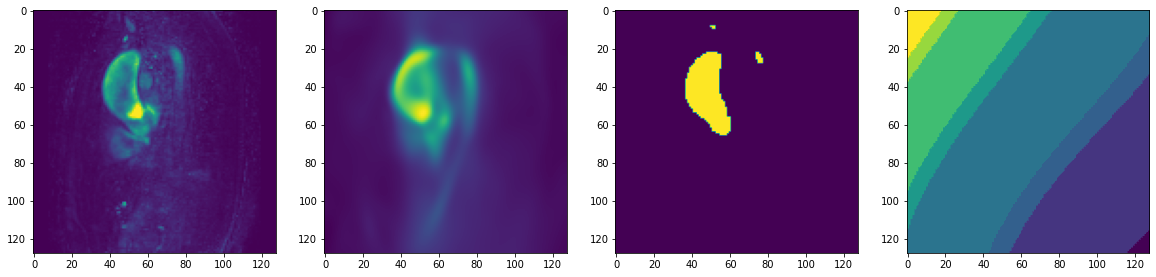

In [14]:
shape = [24, 128, 128]

# ARGS.rotate = True
# ARGS.translate = True
# ARGS.flip = True
# ARGS.crop = True
# ARGS.stretch = True

window = save_output(train_dl, shape=shape, transform=False)

In [15]:
# def gradient(y, x, grad_outputs=None):
#     if grad_outputs is None:
#         grad_outputs = torch.ones_like(y)
#     grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
#     return grad

In [16]:
# grad = gradient(siren_out, coords_out)
# print(grad)

# print(torch.abs(grad.norm(dim=-1)))